# Combining OpenCV's Haar-Like Feature Detection with CNNs
This model looks at combining traditional image processing techniques for facial recognition with CNNs using Tensorflow and Keras.

Sources: [here](https://medium.com/@baikaralkesha/face-detection-using-opencv-in-google-colaboratory-a7529a2bb921) and [here](https://www.tensorflow.org/alpha/tutorials/images/transfer_learning)

## Installation
We first need to install TensorFlow 1.12 because TensorFlow 1.13 countains a BatchNormalizationV1 layer that cannot be converted to TensorFlowJS

In [1]:
!pip install tensorflow==1.12

    100% |████████████████████████████████| 83.1MB 422kB/s 
    100% |████████████████████████████████| 3.1MB 12.6MB/s 
  Found existing installation: tensorboard 1.13.1
    Uninstalling tensorboard-1.13.1:
      Successfully uninstalled tensorboard-1.13.1
  Found existing installation: tensorflow 1.13.1
    Uninstalling tensorflow-1.13.1:
      Successfully uninstalled tensorflow-1.13.1


## Imports

In [2]:
from __future__ import absolute_import, division, print_function

import os
import re

import tensorflow as tf
from tensorflow import keras
import keras.backend as K
print("TensorFlow version is ", tf.__version__)

import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

from google.colab import files
from google.colab import drive

%matplotlib inline

Using TensorFlow backend.


TensorFlow version is  1.12.0


## Data Preprocessing
We now need to get access to the data. 

Data source: [here](https://www.kaggle.com/c/facial-keypoints-detection/data)

## Accessing Data
We can load the data from Google Drive

In [3]:
drive.mount('/content/gdrive')
data_path = '/content/gdrive/My Drive/CS 121/TheNoseArcade/Data/facial_keypoints_detection/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


First, we will try loading a single image:

In [0]:
header = open(data_path + 'training.csv', 'r').readline()[:-1].split(',')
img_col = header.index('Image')
nose_x_col = header.index('nose_tip_x')
nose_y_col = header.index('nose_tip_y')
image_size = 96

In [0]:
def load_image(source_line):
  '''
  Given a source CSV file line, load the image data and x, y coordinates of the 
  person's nose
  '''
  # Prepare the data
  data = source_line[:-1].split(',')
  image_data = [int(pix) for pix in data[img_col].split(' ')]
  
  # Format the data
  img = np.array(image_data).reshape((image_size, image_size))
  nose_x = float(data[nose_x_col])
  nose_y = float(data[nose_y_col])
  
  return img, nose_x, nose_y

In [0]:
train_csv = open(data_path + 'training.csv', 'r').readlines()[1:]
test_csv = open(data_path + 'test.csv', 'r').readlines()[1:]

Test the image loading

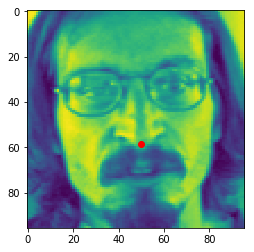

In [57]:
img, x, y = load_image(train_csv[100])
plt.imshow(img)
plt.scatter([x], [y], c='r')

## Create Training and Validation Arrays

In [0]:
def load_csv(lines, inds):
    '''
    For a given set of lines from a data csv, return an array of images and an 
    array of labels
    '''
    # Set up arrays
    data = np.zeros((len(inds), image_size, image_size))
    labels = np.zeros((len(inds), 2))

    # Load in the data
    for i in range(inds.shape[0]):
        data[i], labels[i][0], labels[i][1] = load_image(lines[inds[i]])
        
    data = np.repeat(data[..., np.newaxis], 3, -1).astype(int)

    return data, labels

Now decide which indicies to use for training and which to use for validation. We will reserve 100 images for validation.

In [0]:
all_inds = np.arange(len(train_csv))
valid_inds = np.random.choice(all, size=100, replace=False)
train_inds = all[np.logical_not(np.isin(all, valid))]

In [0]:
train_data, train_labels = load_csv(train_csv, train_inds)
valid_data, valid_labels = load_csv(train_csv, valid_inds)

Finally make sure everything is okay by displaying an image

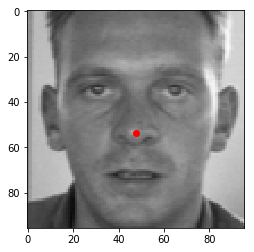

In [130]:
i = 2
plt.imshow(train_data[i])
plt.scatter([train_labels[i][0]], [train_labels[i][1]], c='r')

### Create Image Data Generator with Image Augmentation
We then need to resize the images and create a data generator, to be used for training / validation

For this section, I used an additional source: [here](https://keras.io/preprocessing/image/)

In [0]:
batch_size = 32

# Rescale all images by 1./255 and apply image augmentation
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow(train_data, train_labels,
                batch_size=batch_size)

# Flow validation images in batches of 32 using test_datagen generator
validation_generator = validation_datagen.flow(valid_data, valid_labels,
                batch_size=batch_size)

## Model Set-Up

### Create the base model using a pretrained network

Here we are using MobileNet, but that can always be changed.

In [0]:
IMG_SHAPE = (image_size, image_size, 3)

# Create the base model from the pre-trained model MobileNet
base_model = tf.keras.applications.MobileNetV2(include_top=False,
                                            input_shape=IMG_SHAPE, 
                                            weights='imagenet')

### Freeze the convolutional base
We will freeze the convolutional base created from the previous step and use that as a feature extractor, add a classifier on top of it and train the top-level classifier.

It's important to freeze the convolutional based before we compile and train the model. By freezing (or setting layer.trainable = False), we prevent the weights in these layers from being updated during training.

In [0]:
base_model.trainable = False

### Add back the top layers
Now let's add a few layers on top of the base model:

In [0]:
model = tf.keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(1024, activation=tf.keras.activations.relu),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(2)
])

### Compile the model
You must compile the model before training it. For this, we will create a new metric, the distance between the ground-truth point and our point

In [0]:
def dist_pred(y_true, y_pred):
    return K.sqrt((y_true[0] - y_pred[0])**2 + (y_true[1] - y_pred[1])**2)

In [0]:
lr = 0.0001 # 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=lr), 
              loss='mean_squared_error', 
              metrics=[dist_pred])

In [138]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Model)  (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 3,571,778
Trainable params: 1,313,794
Non-trainable params: 2,257,984
_________________________________________________________________


## Train Top Layers

In [0]:
def train(lr, epochs):
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=lr), 
              loss='mean_squared_error', 
              metrics=[dist_pred])
  steps_per_epoch = train_generator.n // batch_size
  validation_steps = max(validation_generator.n // batch_size, 1)

  history = model.fit_generator(train_generator, 
                                steps_per_epoch = steps_per_epoch,
                                epochs=epochs, 
                                workers=4,
                                validation_data=validation_generator, 
                                validation_steps=validation_steps)

In [170]:
epochs = 1
lr = 0.0001 # 0.0001
train(lr, epochs)

Epoch 1/1
217/217 [==============================] - 159s 732ms/step - loss: 338.9122 - dist_pred: 19.6850 - val_loss: 171.6492 - val_dist_pred: 15.9128


In [171]:
epochs = 1
lr = 0.0001 # 0.0001
train(lr, epochs)

Epoch 1/1
217/217 [==============================] - 160s 736ms/step - loss: 68.3623 - dist_pred: 10.5157 - val_loss: 172.4353 - val_dist_pred: 14.9487


We can try out the results of the model

[[44.220314 60.90461 ]]


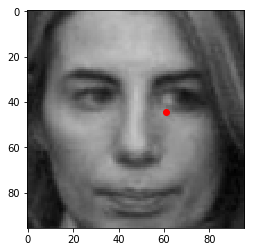

In [172]:
ctr = model.predict(np.expand_dims(valid_data[2], axis=0))
plt.imshow(valid_data[2])
print(ctr)
plt.scatter([ctr[0][1]], [ctr[0][0]], c='r')

## Testing

We can also try this out on other data sets

In [0]:
gt_db_path = '/content/gdrive/My Drive/CS 121/TheNoseArcade/Data/gt_db/'

In [0]:
image = cv2.imread(gt_db_path + 's09/02.jpg')
grayscale_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
face_cascade = cv2.CascadeClassifier('/content/gdrive/My Drive/CS 121/TheNoseArcade/Data/haarcascade_frontalface_default.xml')
box = face_cascade.detectMultiScale(grayscale_image, 1.25, 6)[0]

In [0]:
net_data = image[box[0]:(box[0]+box[2]), box[1]:(box[1] + box[3]), :]
nose = model.predict(np.expand_dims(cv2.resize(net_data, (image_size, image_size)), 
                                    axis=0))[0]

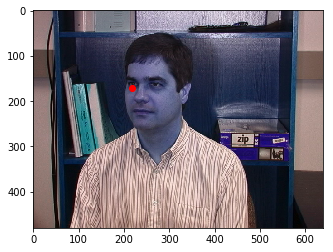

In [191]:
plt.imshow(image)
plt.scatter([box[0] + nose[0]], [box[1] + nose[1]], c='r')

## Saving the Model
First recompile the model so that it no longer uses the accuracy measure, confirm that it is still working, and save it.

In [0]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), 
              loss='mean_squared_error', 
              metrics=[])

In [0]:
model.save('kaggle.h5')
files.download('kaggle.h5')

## Train All Layers

Fine-tune from the 100th layer up

In [0]:
base_model.trainable = True

In [152]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


Now compile and train the model

In [0]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), 
              loss='mean_squared_error', 
              metrics=[dist_pred])

In [154]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Model)  (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 3,571,778
Trainable params: 3,176,386
Non-trainable params: 395,392
_________________________________________________________________


In [155]:
epochs = 1
lr = 0.00001 # 0.0001
train(lr, epochs)

Epoch 1/1
217/217 [==============================] - 271s 1s/step - loss: 51.3246 - dist_pred: 8.9886 - val_loss: 131.9000 - val_dist_pred: 16.7317
